In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Input, BatchNormalization, Dropout
from keras.models import Model

from sklearn.metrics import auc, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

### Anomaly Detection using Autoencoders

Unstructured data can be in form of images, text, sound etc. and in order to build Machine Learning models on them, we need to convert them into numeric form that is understood or processed by models/networks. At the same time, the model predictions need to be converted back to interpretable format similar to input or not, otherwise.

Generally, any ML pipeline is as follows:

<code>Data Extraction --> Encoding --> Model Training --> Model Predictions --> Decoding</code>

The encoding/decoding step are optional and only done if required. For example: 
1. Language Translation/Text Summarization/Question Answering: converting text (input) to text (output)
2. Image Segmentation: converting image (input) to image (output) 
3. Image Captioning: converting image (input) to text (output)
4. Image Retrieval: converting text (input) to output (image)

This is commonly called as **Encoder-Decoder** model. Autoencoders are special types of Encoder-Decoder models where input space is similar to output space. There are different types of autoencoders:
1. Regularized Autoencoders
2. Denoised Autoencoders (DAE)
3. Variational Autoencoders (VAE)

#### Dataset Link: [Dogs v/s Cats](https://www.kaggle.com/c/dogs-vs-cats)

In [2]:
img_size = 64
learning_rate = 1E-3
n_epochs = 20
batch_size = 32
sample_pct = 0.2
val_pct = 0.2
anomaly_pct = 0.1

data_path = 'anomaly_dataset/dogs-vs-cats/'
train_data_path = data_path + 'train/'
test_data_path = data_path + 'test1/'

In this notebook, we will use autoencoders to perform the task of **anomaly detection**.

We will build a model to learn the distribution of non-anomaly images by learning to reconstruct these images using DAEs. As the model has learnt distribution of non-anomaly class images, reconstructing images of any other class (anomaly) should be difficult. And so, we can keep threshold on reconstruction loss and based on that classify whether the image is anomaly or non-anomaly.

Based on range of thresholds, we can formulate this as classification problem and consequently also plot ROC Curve and calculate AUROC.

We will consider **Cats v/s Dogs** dataset. We will train on dog images, learning representations of it in constrained space. At the same time, we will consider cat images as anomalies and try to predict them using our learnt model. We expect that the model should have difficulty in reconstructing the cat image, and so the reconstruction loss is higher for it compared to that for dog image.

We will build a small model having downsampling (encoder) and upsampling (decoder) path, similar to UNet, ensuring the size of output is same as that of input, and minimize the reconstruction loss using MSE loss function. We will train only on non-anomaly images.

In [3]:
def process_data(data_path, images_idxs, img_size):
    dog_images = []
    cat_images = []
    
    for file in tqdm(images_idxs, total=len(images_idxs)):
        img_path = data_path + file
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        label = file.split('.')[0]
        if label == 'cat':
            cat_images.append(img)
        else:
            dog_images.append(img)
        
    cat_images = np.array(cat_images)
    dog_images = np.array(dog_images)
    return cat_images, dog_images

In [4]:
images_path = os.listdir(train_data_path)
np.random.shuffle(images_path)
sample_size = int(sample_pct * len(images_path))
train_images_idxs = images_path[:sample_size]
val_images_idxs = images_path[sample_size: int((1 + val_pct) * sample_size)]

train_cat_images, train_dog_images = process_data(train_data_path, train_images_idxs, img_size)
val_cat_images, val_dog_images = process_data(train_data_path, val_images_idxs, img_size)

train_cat_images.shape, train_dog_images.shape, val_cat_images.shape, val_dog_images.shape

100%|██████████| 1000/1000 [00:04<00:00, 241.97it/s]


((2516, 64, 64), (2484, 64, 64), (503, 64, 64), (497, 64, 64))

In [5]:
num_anomaly_examples = int(anomaly_pct * len(train_dog_images))
anomaly_idxs = np.random.choice(np.arange(len(train_cat_images)), num_anomaly_examples, replace=False)
anomaly_imgs = train_cat_images[anomaly_idxs]
non_anomaly_imgs = train_dog_images

print('Anomaly Images:', anomaly_imgs.shape)
print('Non-Anomaly Images:', non_anomaly_imgs.shape)

Anomaly Images: (248, 64, 64)
Non-Anomaly Images: (2484, 64, 64)


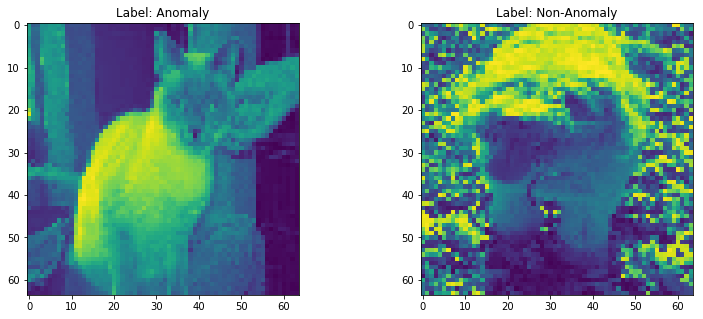

In [6]:
idx = 23
img1 = anomaly_imgs[idx]
img2 = non_anomaly_imgs[idx]

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(img1)
plt.title('Label: Anomaly')

plt.subplot(132)
plt.imshow(img2)
plt.title('Label: Non-Anomaly')
plt.show()

In [7]:
inp = Input(shape=(img_size, img_size, 1))

# encoder
x = Conv2D(32, kernel_size=(2,2), activation='relu')(inp)
x = MaxPool2D(pool_size=(2,2))(x)

# embedding
x = BatchNormalization()(x)
emb = Dropout(0.25)(x)

# decoder
x = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), output_padding=(1,1), activation='relu')(emb)
out = Conv2DTranspose(1, kernel_size=(2,2), activation='relu')(x)

model = Model(inputs = inp, outputs = out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 63, 63, 32)       4128  

2022-04-04 02:48:59.429328: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(non_anomaly_imgs, non_anomaly_imgs, epochs = n_epochs, shuffle = True, 
                    batch_size=batch_size, validation_split = 0.2, verbose=1)

Epoch 1/20
63/63 [==============================] - 6s 84ms/step - loss: 17538.0059 - val_loss: 12549.6230
Epoch 2/20
63/63 [==============================] - 5s 84ms/step - loss: 13350.0312 - val_loss: 3872.9573
Epoch 3/20
63/63 [==============================] - 5s 82ms/step - loss: 5285.0835 - val_loss: 2382.1562
Epoch 4/20
63/63 [==============================] - 5s 81ms/step - loss: 2148.6931 - val_loss: 1606.8405
Epoch 5/20
63/63 [==============================] - 5s 84ms/step - loss: 1714.5304 - val_loss: 2244.1655
Epoch 6/20
63/63 [==============================] - 5s 82ms/step - loss: 1514.1650 - val_loss: 2092.3484
Epoch 7/20
63/63 [==============================] - 5s 83ms/step - loss: 1445.4143 - val_loss: 1999.1494
Epoch 8/20
63/63 [==============================] - 5s 83ms/step - loss: 1400.3673 - val_loss: 1812.8020
Epoch 9/20
63/63 [==============================] - 5s 83ms/step - loss: 1372.6182 - val_loss: 1643.8402
Epoch 10/20
63/63 [==============================] -

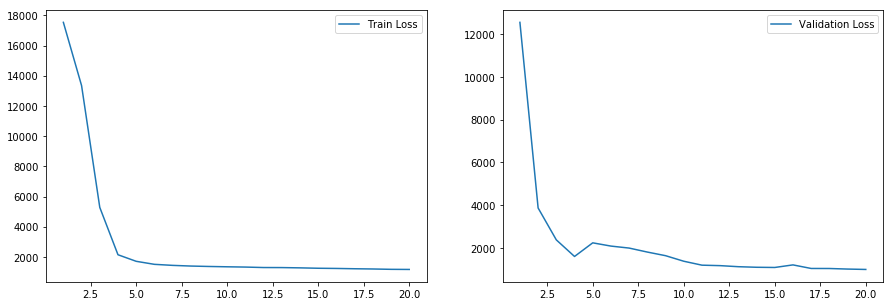

In [9]:
def plotting(train_loss, val_loss):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(range(1, n_epochs+1), train_loss, label = 'Train Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(range(1, n_epochs+1), val_loss, label = 'Validation Loss')
    plt.legend()

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plotting(train_loss, val_loss)    

In [10]:
def predict_example(idx, X_true, X_pred):
    gt = np.squeeze(X_true[idx])
    prediction = np.squeeze(X_pred[idx])

    plt.subplot(121)
    plt.imshow(gt)

    plt.subplot(122)
    plt.imshow(prediction)
    plt.show()

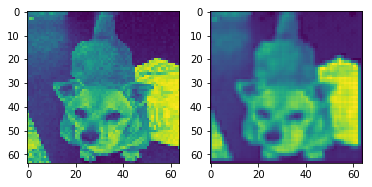

In [11]:
non_anomaly_pred = model.predict(non_anomaly_imgs)
non_anomaly_pred = np.squeeze(non_anomaly_pred)

idx = 67
predict_example(idx, non_anomaly_imgs, non_anomaly_pred)

In [12]:
def get_reconstuction_loss(X_true, X_pred):
    assert X_true.shape == X_pred.shape
    return np.mean(np.square(X_true - X_pred), axis=(1,2))

def find_outcome(actual_label, predicted_label):
    if actual_label == predicted_label:
        if actual_label == 1:
            return 'TP'
        else:
            return 'TN'
    else:
        if actual_label == 1:
            return 'FN'
        else:
            return 'FP'
        
def calculate_roc_metrics(y_true, val_loss, threshold):
    y_pred = (val_loss >= threshold) * 1
    outcomes = np.array(list(map(lambda x,y: find_outcome(x,y), y_true, y_pred)))
    tp = sum(outcomes=='TP')
    tn = sum(outcomes=='TN')
    fp = sum(outcomes=='FP')
    fn = sum(outcomes=='FN')
    
    if tp==0:
        tpr = 0
    else:
        tpr = tp/(tp+fn)
    if fp==0:
        fpr = 0 
    else:
        fpr = fp/(fp+tn)
        
    return fpr, tpr

In [13]:
# randomizing validation dataset
X_val = np.vstack((val_cat_images, val_dog_images))
y_val = np.array([1] * len(val_cat_images) + [0] * len(val_dog_images))
val_idxs = np.arange(len(X_val))
np.random.shuffle(val_idxs)
X_val = X_val[val_idxs]
y_val = y_val[val_idxs]

# getting reconstruction loss
X_pred = model.predict(X_val)
X_pred = np.squeeze(X_pred)
val_loss = get_reconstuction_loss(X_val, X_pred)
val_loss = val_loss.reshape(-1,1)

# normalizing loss
scaler = MinMaxScaler()
scaled_val_loss = scaler.fit_transform(val_loss).ravel()

AUC:  0.4769491701701261


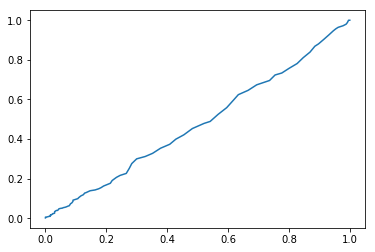

In [14]:
thresholds = np.linspace(0, 1, 100)
roc_metrics = np.array(list(map(lambda x: calculate_roc_metrics(y_val, scaled_val_loss, x), thresholds)))
fpr = roc_metrics[:,0]
tpr = roc_metrics[:,1]

print('AUC: ', auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.show()

Identifying closest point on ROC Curve from (1, 1) to find the optimum threshold. 

In [15]:
dist = np.sqrt(fpr**2 + (1-tpr)**2)
idx = np.argsort(dist)[0]
best_threshold = thresholds[idx]

y_pred = (scaled_val_loss.ravel() >= best_threshold) * 1
print('Accuracy Score:', accuracy_score(y_val, y_pred))

Accuracy Score: 0.485
